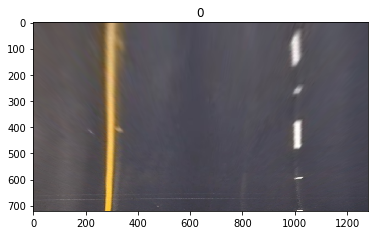

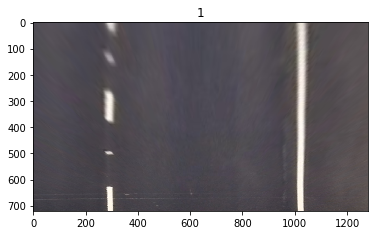

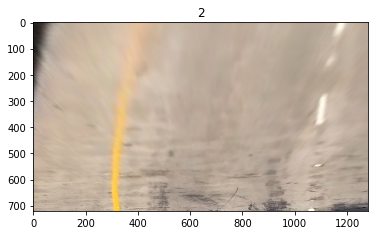

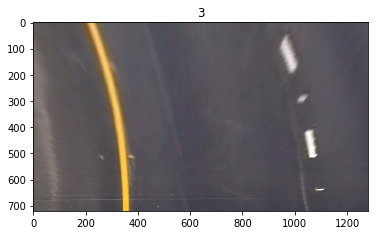

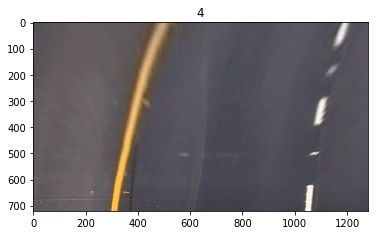

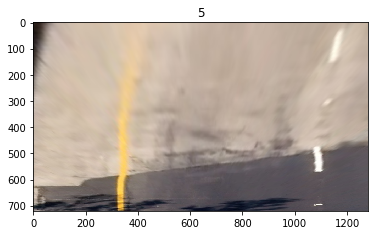

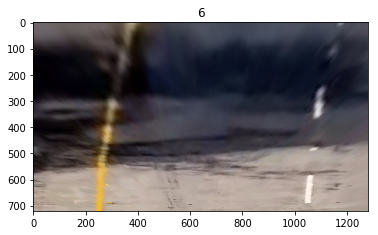

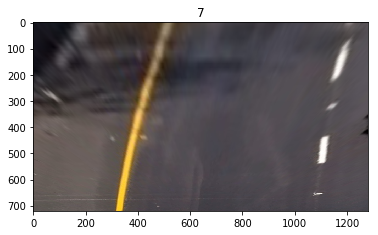

In [1]:
from find_lane import *
%matplotlib qt
%matplotlib inline 

# Calibrate using checkerboard
calibration_img_files = glob.glob('./camera_cal/*.jpg')
lane_shape = [(584, 458), (701, 458), (295, 665), (1022, 665)]
camera = DashboardCamera(calibration_img_files, chessboard_size=(9, 6), lane_shape=lane_shape)

test_img_files = glob.glob('./test_images/*.jpg')
test_imgs = [camera.warp_to_overhead(camera.undistort(plt.imread(f))) for f in test_img_files]

for i, img in enumerate(test_imgs):
    plt.figure()
    plt.imshow(img)
    plt.title(i)

In [17]:
img_files = glob.glob('./train/*.png')
imgs = [camera.warp_to_overhead(camera.undistort(plt.imread(f))) for f in img_files]

from scipy.misc import imsave
for i, img in enumerate(imgs):
    imsave('./train/road_{}.jpg'.format(i+8), img)

In [16]:
test_img_files = glob.glob('./tests/data/*.jpg')
cropped_imgs = [plt.imread(f) for f in test_img_files]

for i, img in enumerate(cropped_imgs):
    plt.figure()
    plt.imshow(img)
    plt.title(i)

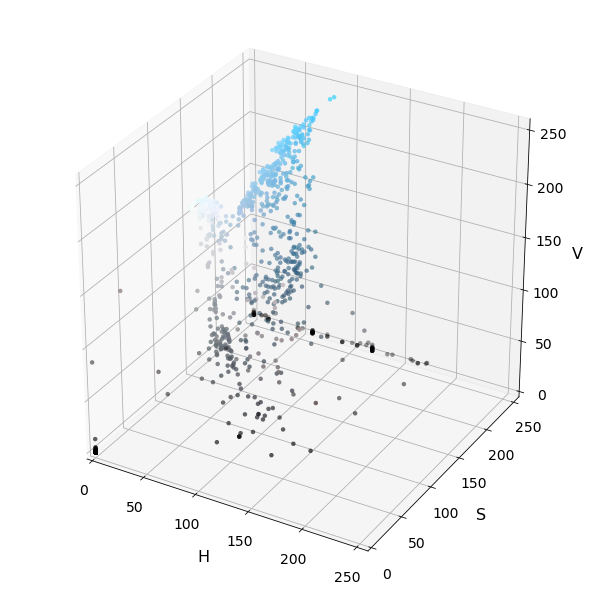

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d_color(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cropped_imgs[0]

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d_color(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

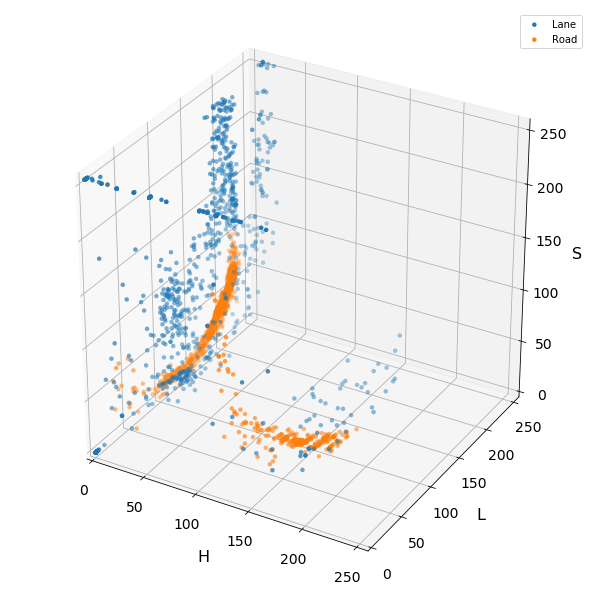

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def subsample(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'LAB':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    else:
        img = np.copy(img)
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
    return img_small

def plot3d_compare(img1, img2, name1, name2, space='RBG', axis_limits=[(0, 255), (0, 255), (0, 255)]):
    pixels1 = subsample(img1, space)
    pixels2 = subsample(img2, space)
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(space[0], fontsize=16, labelpad=16)
    ax.set_ylabel(space[1], fontsize=16, labelpad=16)
    ax.set_zlabel(space[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels1[:, :, 0].ravel(),
        pixels1[:, :, 1].ravel(),
        pixels1[:, :, 2].ravel(), edgecolors='none')
    ax.scatter(
        pixels2[:, :, 0].ravel(),
        pixels2[:, :, 1].ravel(),
        pixels2[:, :, 2].ravel(), edgecolors='none')
    ax.legend([name1, name2])

    return ax  # return Axes3D object for further manipulation


# Plot and show
plot3d_compare(cropped_imgs[0], cropped_imgs[5], 'Lane', 'Road', 'HLS')

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

def extract_features(imgs, cspace='RGB'):
    features = []
    for i, image in enumerate(imgs):
        print('Getting image', i, 'features...')
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else:
            feature_image = np.copy(image)
        
        for row in feature_image:
            for xyz in row:
                if xyz[0] == 0 and xyz[1] == 0 and xyz[2] == 0:
                    continue
                features.append(xyz)
    return features


# Read in car and non-car images
print('Images:', len(cropped_imgs))
lane = [cropped_imgs[0]]
notlane = [cropped_imgs[1]]
notlane.append(cropped_imgs[2])
notlane.append(cropped_imgs[5])
print('Lane imgs:', len(lane))
print('Notlane imgs:', len(notlane))


# Get features
cspace = 'HSV'
print('Getting features')
lane_features = extract_features(lane, cspace=cspace)
notlane_features = extract_features(notlane, cspace=cspace)
print('Features Found')

print('Lanes:', len(lane_features))
print('Not lanes:', len(notlane_features))

print('\nBalancing sets')
scale = 4
notlane_features_balanced = []
for i in range(len(notlane_features)):
    if i % ((len(notlane_features)) // len(lane_features))//scale == 0:
        notlane_features_balanced.append(notlane_features[i])
notlane_features = notlane_features_balanced
print('Not lanes:', len(notlane_features))

# Features vector
X = np.vstack((lane_features, notlane_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Labels vector
y = np.hstack((np.ones(len(lane_features)), np.zeros(len(notlane_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.4, random_state=rand_state)

print('\nTotal number of samples:', len(X))
print('Training samples:', len(X_train))
print('Test samples:', len(X_test))
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
print('\nTraining with SVC')
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round((t2-t)/60, 1), 'minutes used to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Images: 8
Lane imgs: 1
Notlane imgs: 3
Getting features
Getting image 0 features...
Getting image 0 features...
Getting image 1 features...
Getting image 2 features...
Features Found
Lanes: 322045
Not lanes: 2510717

Balancing sets
Not lanes: 2510717

Total number of samples: 2832762
Training samples: 1699657
Test samples: 1133105
Feature vector length: 3

Training with SVC
6.4 minutes used to train SVC...
Test Accuracy of SVC =  0.9391
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
0.02052 Seconds to predict 10 labels with SVC


0.06104 Seconds to predict classify one image of pixels with SVC
0.06305 Seconds to predict classify one image of pixels with SVC
0.06305 Seconds to predict classify one image of pixels with SVC
0.06404 Seconds to predict classify one image of pixels with SVC
0.05976 Seconds to predict classify one image of pixels with SVC
0.05904 Seconds to predict classify one image of pixels with SVC
0.06205 Seconds to predict classify one image of pixels with SVC
0.06587 Seconds to predict classify one image of pixels with SVC


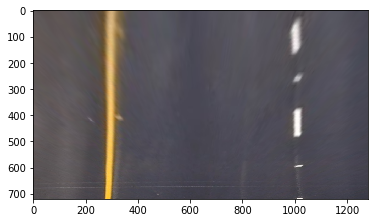

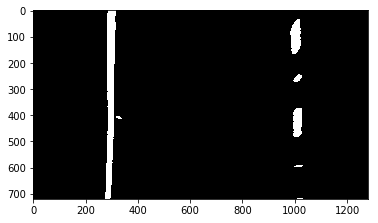

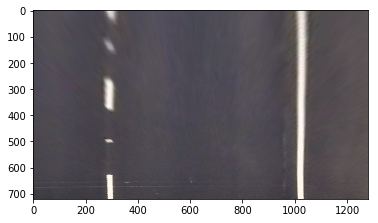

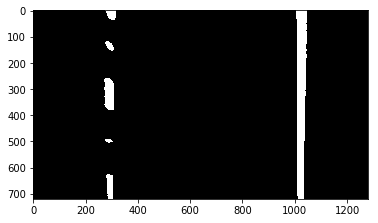

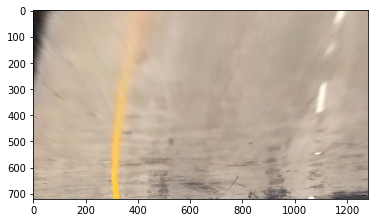

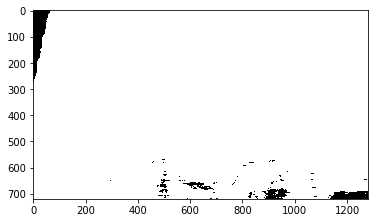

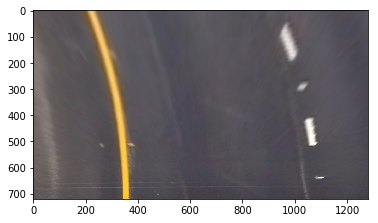

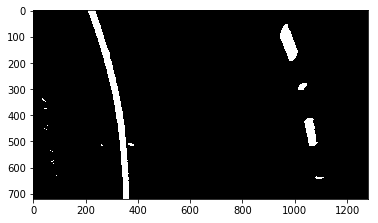

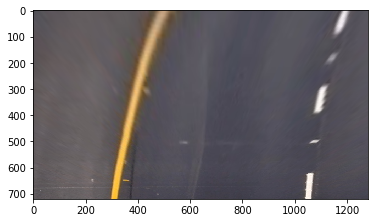

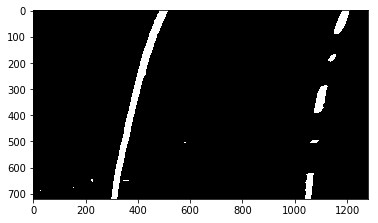

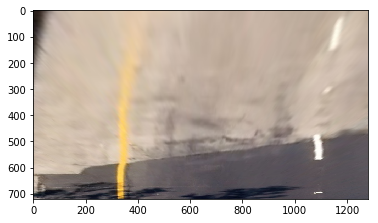

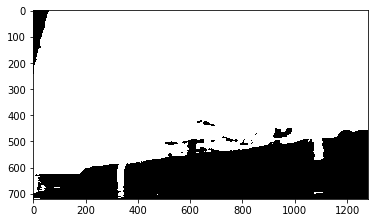

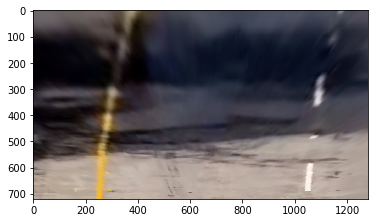

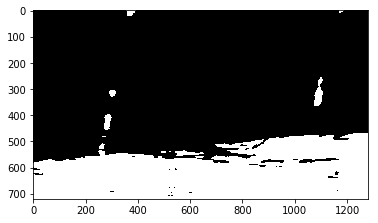

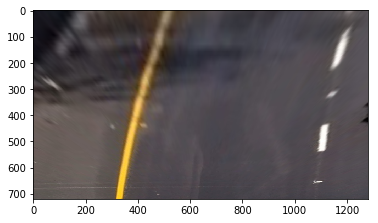

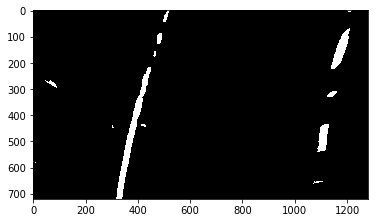

In [14]:
challenge_img_files = glob.glob('./tests/challenge*.png')
challenge_imgs = [camera.warp_to_overhead(camera.undistort(plt.imread(f))) for f in challenge_img_files]

for im in test_imgs:
    plt.figure()
    plt.imshow(im)
    
    t=time.time()
    img = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    img = np.copy(im)
    mask = np.zeros(img.shape[0:2])

    img_h, img_w = mask.shape
    
    mask = svc.predict(X_scaler.transform(img.reshape((img_h*img_w, 3))))
    mask = mask.reshape((img_h, img_w))
    
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict classify one image of pixels with SVC')
    
    plt.figure()
    plt.imshow(mask, cmap='gray')